In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import torchvision.models as models
import time

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [32]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
dataset_path = './Pistachio_Image'
dataset = datasets.ImageFolder(root = dataset_path, transform=transform)


In [34]:
len(dataset)

2148

In [35]:
2148*0.75

1611.0

In [36]:
class_names = dataset.classes
class_names

['Kirmizi_Pistachio', 'Siirt_Pistachio']

In [37]:
num_classes = len(class_names)
num_classes

2

In [38]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

In [39]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [40]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False)

In [41]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [42]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


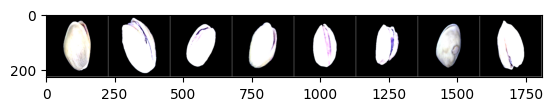

In [43]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
imshow(torchvision.utils.make_grid(images[:8]))

In [44]:
labels[:8]

tensor([1, 1, 1, 1, 1, 0, 0, 0])

In [45]:
[dataset.classes[i] for i in labels[:8]]

['Siirt_Pistachio',
 'Siirt_Pistachio',
 'Siirt_Pistachio',
 'Siirt_Pistachio',
 'Siirt_Pistachio',
 'Kirmizi_Pistachio',
 'Kirmizi_Pistachio',
 'Kirmizi_Pistachio']

In [47]:
class PistachioCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2 ,padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 ,stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [49]:
len(train_loader.dataset)

1611

In [55]:
def train_model(model, criterion, optimizer , epochs = 10):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num,(images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (batch_num+1)%10 ==0:
                print(f"Batch: {batch_num+1},Epoch: {epoch+1} ,loss: {loss.item():.4f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch" {epoch+1}/{epochs}, Epoch Loss: {epoch_loss:.4f}')

        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end  = time.time()
    print(f"Execution Time: {end - start} seconds")

    return all_labels, all_predictions
    

In [67]:
model = PistachioCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

all_labels , all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10,Epoch: 1 ,loss: 0.6636
Batch: 20,Epoch: 1 ,loss: 0.5222
Batch: 30,Epoch: 1 ,loss: 0.4184
Batch: 40,Epoch: 1 ,loss: 0.4533
Batch: 50,Epoch: 1 ,loss: 0.3192
Epoch" 1/10, Epoch Loss: 0.8198
*** Validation Accuracy: 78.96% ***
Batch: 10,Epoch: 2 ,loss: 0.3985
Batch: 20,Epoch: 2 ,loss: 0.1929
Batch: 30,Epoch: 2 ,loss: 0.3530
Batch: 40,Epoch: 2 ,loss: 0.1863
Batch: 50,Epoch: 2 ,loss: 0.4108
Epoch" 2/10, Epoch Loss: 0.3783
*** Validation Accuracy: 82.50% ***
Batch: 10,Epoch: 3 ,loss: 0.3153
Batch: 20,Epoch: 3 ,loss: 0.3610
Batch: 30,Epoch: 3 ,loss: 0.4252
Batch: 40,Epoch: 3 ,loss: 0.3102
Batch: 50,Epoch: 3 ,loss: 0.5138
Epoch" 3/10, Epoch Loss: 0.3523
*** Validation Accuracy: 84.17% ***
Batch: 10,Epoch: 4 ,loss: 0.4683
Batch: 20,Epoch: 4 ,loss: 0.4221
Batch: 30,Epoch: 4 ,loss: 0.4534
Batch: 40,Epoch: 4 ,loss: 0.2312
Batch: 50,Epoch: 4 ,loss: 0.4206
Epoch" 4/10, Epoch Loss: 0.3425
*** Validation Accuracy: 84.73% ***
Batch: 10,Epoch: 5 ,loss: 0.2375
Batch: 20,Epoch: 5 ,loss: 0.4710
Ba

In [64]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       310
           1       0.87      0.91      0.89       227

    accuracy                           0.91       537
   macro avg       0.90      0.91      0.90       537
weighted avg       0.91      0.91      0.91       537



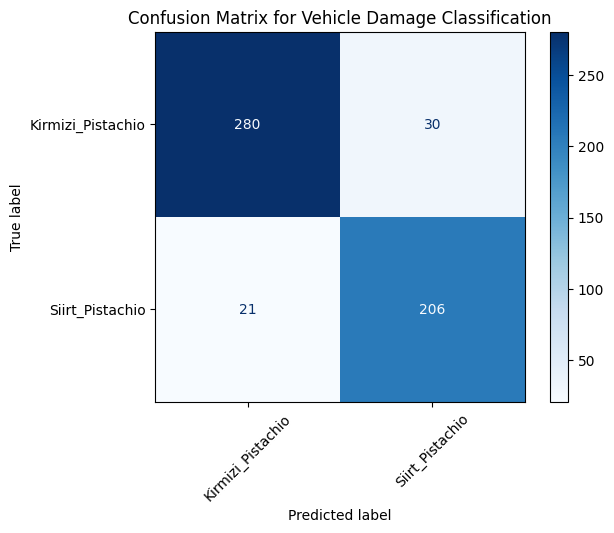

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [63]:
torch.save(model.state_dict(), 'saved_model.pth')